In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def parse(log):
    benchmarks = []
    for line in log.split('\n'):
        match = re.search( r'\[(.+)\]\s+mean =\s+(.+)\(ns\)\s+sd =\s+(.+)\(ns\)\s+nsample =\s+(\d+)', line)
        if match:
            benchmarks.append({
                'mso': match.group(1).strip(),
                'mean_ns': float(match.group(2)),
                'std_ns': float(match.group(3)),
                'nsamples': int(match.group(4))
            })
    return pd.DataFrame(benchmarks)

In [22]:
from glob import glob
from os.path import basename

def read_measured(path_glob):
    measured = []
    for path in glob(path_glob):
        if 'spmm' in path:
            continue
        match = re.search(r'(.+)-(\d+)\.log', basename(path))
        batch_name = match.group(1)
        simd_width = int(match.group(2))
        size = None

        with open(path) as f:
            log = f.read()

            # setop
            if (match_a := re.search(r'Load a: (\d+)', log)) and (match_b := re.search(r'Load b: (\d+)', log)):
                size = int(match_a.group(1)) + int(match_b.group(1))
            # joinop
            elif (match_a := re.search(r'Load aidx: (\d+)', log)) and (match_b := re.search(r'Load bidx: (\d+)', log)):
                size = int(match_a.group(1)) + int(match_b.group(1))
            # join-*
            elif match := re.search(r'Tensor\s+: mode =  (\d), .+, nnz =  (\d+)', log):
                size = 2 * int(match.group(1)) * int(match.group(2))
            # sort & sortkv
            elif match := re.search(r'Generated random vector length = (\d+)', log):
                size = int(match.group(1))

            df = parse(log)
            if len(df) == 0:
                continue
            df = df.loc[df['mean_ns'].notna()]
            df['batch_name'] = batch_name
            df['simd_width'] = simd_width
            df.loc[df['mso'].str.contains('Scalar'), 'simd_width'] = 1
            df['size'] = size
            df['throughput'] = df['size'] / df['mean_ns']
            measured.append(df)

    return pd.concat(measured)

# Runtime

In [10]:
import re
import pandas as pd
from glob import glob
from os.path import basename, dirname, splitext, join

pattern = re.compile(r"(\w+)\s+(\d+)m(\d+\.\d+)s")
times = []
for directory in glob('results/*/'):
    env = basename(dirname(directory))
    for path in glob(join(directory, 'experiment-1-4/*.log')):
        with open(path) as f:
            time_dict = {'experiment': splitext(basename(path))[0], 'env': env}
            for line in f:
                match = pattern.match(line)
                if match:
                    category, minutes, seconds = match.groups()
                    time_dict[category] = int(minutes) * 60 + float(seconds)
            times.append(time_dict)

df = pd.DataFrame(times)
df

,experiment,env,real,user,sys
0,join-addmul-matrix-16,linux,23.744,23.680,0.064
1,join-addmul-matrix-32,linux,22.090,22.021,0.069
2,join-addmul-matrix-4,linux,83.486,83.402,0.084
3,join-addmul-matrix-64,linux,20.832,20.784,0.048
4,join-addmul-matrix-8,linux,29.189,29.129,0.061
...,...,...,...,...,...
181,spmm-report-16,windows,0.175,0.165,0.010
182,spmm-report-32,windows,0.184,0.165,0.019
183,spmm-report-4,windows,0.181,0.150,0.030
184,spmm-report-64,windows,0.172,0.125,0.048


In [19]:
df.groupby('env').sum(numeric_only=True) / 60

,real,user,sys
env,,,
linux,187.193217,854.566317,0.131383
mac,514.210883,144.383383,0.144133
windows,62.472533,351.046617,0.059033


In [20]:
df[df['env'] != 'mac'].sort_values(by='real', ascending=False)

,experiment,env,real,user,sys
57,spmm-4,linux,8407.276,48453.604,3.937
178,spmm-4,windows,2933.014,20252.990,1.671
52,sortkv-4,linux,418.656,418.596,0.060
47,sort-4,linux,308.492,308.427,0.065
37,joinop-4,linux,143.078,143.025,0.052
...,...,...,...,...,...
181,spmm-report-16,windows,0.175,0.165,0.010
179,spmm-64,windows,0.174,0.144,0.031
184,spmm-report-64,windows,0.172,0.125,0.048
180,spmm-8,windows,0.171,0.161,0.010


In [24]:
df[df['experiment'].str.startswith('spmm')].groupby('env').sum(numeric_only=True) / 60

,real,user,sys
env,,,
linux,140.171867,807.603667,0.07265
mac,0.000000,0.000000,0.00000
windows,48.910333,337.573300,0.03115


In [25]:
854.566317 - 807.603667

46.96265000000005

In [26]:
351.046617 - 337.573300

13.473317000000009

# Experiment 1: Replicated Chart

In [ ]:
measured = read_measured('results/windows/experiment-1-4/*.log')

In [120]:
set_union = measured[measured['batch_name'].isin(('setop', 'joinop'))].copy()
set_union['mso'] = set_union['mso'].str.replace(' Scalar', '')
set_union['mso'] = set_union['mso'].str.replace(' SIMD', '')
set_union['mso'] = set_union.apply(lambda x: 'Set-' + x['mso'] if x['batch_name'] == 'setop' else x['mso'], axis=1)
set_union = set_union.sort_values(by='simd_width')
set_union['mso'].unique()

array(['Join-Inner', 'Join-Left-Ex', 'Set-Diff', 'Join-Outer-Ex',
       'Set-XOR', 'Set-Intersect', 'Join-Left', 'Join-Full-Outer',
       'Set-Union'], dtype=object)

C:\Users\Jon\AppData\Local\Temp\ipykernel_28496\3654055611.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20').colors
C:\Users\Jon\AppData\Local\Temp\ipykernel_28496\3654055611.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bar_container = plt.bar([j + i * group_width for j in range(num_msos)], group['throughput'], width=group_width, label=simd, color=plt.cm.get_cmap('tab20')(i))


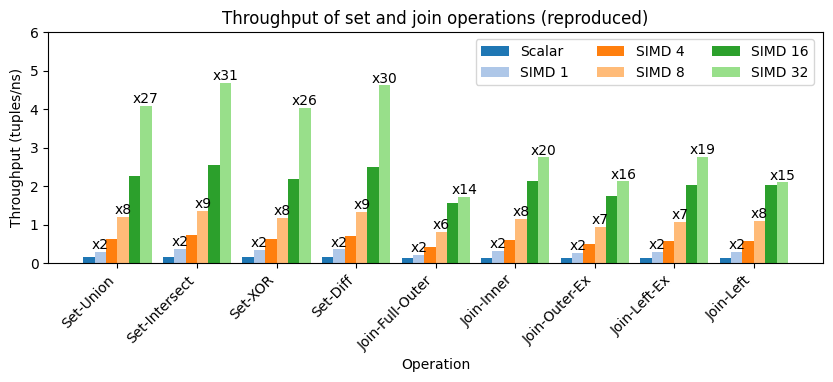

In [154]:
set_union = measured[measured['batch_name'].isin(('setop', 'joinop'))].copy()
set_union['mso'] = set_union['mso'].str.replace(' Scalar', '')
set_union['mso'] = set_union['mso'].str.replace(' SIMD', '')
set_union['mso'] = set_union.apply(lambda x: 'Set-' + x['mso'] if x['batch_name'] == 'setop' else x['mso'], axis=1)

# Order mso groups
ordered_msos = ['Set-Union', 'Set-Intersect', 'Set-XOR', 'Set-Diff', 'Join-Full-Outer', 'Join-Inner', 'Join-Outer-Ex', 'Join-Left-Ex', 'Join-Left']
set_union['mso'] = pd.Categorical(set_union['mso'], categories=ordered_msos, ordered=True)
set_union = set_union.sort_values(['mso', 'simd_width'])

# Group data by 'simd_width'
grouped = set_union.groupby('simd_width')

# Calculate speedups compared to simd_width=1
simd_width_1 = set_union[set_union['simd_width'] == 1].set_index('mso')['throughput']
set_union['speedup'] = set_union.apply(lambda x: x['throughput'] / simd_width_1.loc[x['mso']], axis=1)

# Plotting the bar chart
plt.figure(figsize=(10, 3))
colors = plt.cm.get_cmap('tab20').colors

msos = set_union['mso'].unique()
num_msos = len(msos)
num_groups = len(grouped)
group_width = 1 / (num_groups + 1)

for i, (simd, group) in enumerate(grouped):
    bar_container = plt.bar([j + i * group_width for j in range(num_msos)], group['throughput'], width=group_width, label=simd, color=plt.cm.get_cmap('tab20')(i))

    # Add black text labels on top of each bar when i is odd
    if i % 2 == 1:
        for bar, speedup in zip(bar_container, group['speedup']):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"x{int(round(speedup))}", ha='center', va='bottom', color='black')

plt.xlabel('Operation')
plt.ylabel('Throughput (tuples/ns)')
plt.title('Throughput of set and join operations (reproduced)')

# Set x-axis ticks and labels
tick_positions = [j + 0.5 * group_width * (num_groups - 1) for j in range(num_msos)]
plt.xticks(tick_positions, msos, rotation=45, ha='right')

# Set y-axis limit
plt.ylim(top=6)

# Add legend
legend_labels = [f'Scalar'] + [f'SIMD {int(simd)}' for simd in set_union['simd_width'].unique()]
legend = plt.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.77, 1), ncol=3)

# Remove the title from the legend
legend.set_title(None)

plt.show()

# Experiments 1-4: Difference between envs

In [4]:
windows = read_measured('results/windows/experiment-1-4/*.log')
linux = read_measured('results/linux/experiment-1-4/*.log')
mac = read_measured('results/mac/experiment-1-4/*.log')

In [5]:
comparison = pd.merge(
    left=windows[['batch_name', 'mso', 'simd_width', 'mean_ns']].rename(columns={'mean_ns': 'mean_windows'}),
    right=linux[['batch_name', 'mso', 'simd_width', 'mean_ns']].rename(columns={'mean_ns': 'mean_linux'}),
    on=['batch_name', 'mso', 'simd_width']
)

comparison = pd.merge(
    left=comparison[['batch_name', 'mso', 'simd_width', 'mean_windows', 'mean_linux']],
    right=mac[['batch_name', 'mso', 'simd_width', 'mean_ns']].rename(columns={'mean_ns': 'mean_mac'}),
    on=['batch_name', 'mso', 'simd_width']
)

comparison

,batch_name,mso,simd_width,mean_windows,mean_linux,mean_mac
0,join-addmul-matrix,Add SIMD,16,39200.0,39200.0,39200.0
1,join-addmul-matrix,Mul SIMD,16,21800.0,21800.0,21800.0
2,join-addmul-matrix,Add SIMD,32,20100.0,20100.0,20100.0
3,join-addmul-matrix,Mul SIMD,32,11800.0,11800.0,11800.0
4,join-addmul-matrix,Add Scalar,1,202000.0,202000.0,202000.0
...,...,...,...,...,...,...
131,sortkv,Bramas SIMD (kv),4,1190000.0,1190000.0,1190000.0
132,sortkv,Proposed SIMD (kv),64,37400.0,37400.0,37400.0
133,sortkv,Bramas SIMD (kv),64,173000.0,173000.0,173000.0
134,sortkv,Proposed SIMD (kv),8,252000.0,252000.0,252000.0


In [13]:
comparison['env_std'] = comparison[['mean_windows', 'mean_linux', 'mean_mac']].std(axis=1)
comparison.sort_values(by='env_std', ascending=False)

,batch_name,mso,simd_width,mean_windows,mean_linux,mean_mac,env_std
56,join-shortestpath-tensor,ShortPath Scalar,1,268000.0,266000.0,266000.0,1154.700538
74,joinop,Join-Outer-Ex Scalar,1,152000.0,153000.0,152000.0,577.350269
72,joinop,Join-Inner Scalar,1,143000.0,144000.0,144000.0,577.350269
98,setop,Union Scalar,1,131000.0,132000.0,132000.0,577.350269
102,setop,XOR Scalar,1,130000.0,131000.0,130000.0,577.350269
...,...,...,...,...,...,...,...
36,join-mulcomplex-matrix,Mul ReIm SIMD,16,31500.0,31500.0,31500.0,0.000000
35,join-addmul-vector,Mul SIMD,8,34900.0,34900.0,34900.0,0.000000
34,join-addmul-vector,Add SIMD,8,53900.0,53900.0,53900.0,0.000000
33,join-addmul-vector,Mul SIMD,64,7380.0,7380.0,7380.0,0.000000


In [26]:
len(comparison[(comparison['env_std'] == 0) & (comparison['simd_width'] == 1)]) / len(comparison)

0.09558823529411764

In [25]:
comparison.loc[comparison['env_std'] != 0, 'env_std'].median()

57.735026918962575

In [29]:
comparison.loc[comparison['env_std'] != 0, 'mean_linux'].median()

21500.0

In [27]:
comparison.mean()

C:\Users\Jon\AppData\Local\Temp\ipykernel_10044\3445863915.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  comparison.mean()


simd_width          20.286765
mean_windows    121059.338235
mean_linux      121102.941176
mean_mac        121066.764706
env_std             54.665571
dtype: float64

In [30]:
57.735026918962575 / 21500.0

0.0026853500892540733

# Experiments 1-4: Difference with expectation

In [4]:
windows = read_measured('results/windows/experiment-1-4/*.log')
windows['env'] = 'windows'

linux = read_measured('results/linux/experiment-1-4/*.log')
linux['env'] = 'linux'

measured = pd.concat([windows, linux])
measured

,mso,mean_ns,std_ns,nsamples,batch_name,simd_width,size,throughput,env
1,Add SIMD,39200.0,184.0,5,join-addmul-matrix,16,40000,1.020408,windows
3,Mul SIMD,21800.0,228.0,5,join-addmul-matrix,16,40000,1.834862,windows
1,Add SIMD,20100.0,544.0,5,join-addmul-matrix,32,40000,1.990050,windows
3,Mul SIMD,11800.0,101.0,5,join-addmul-matrix,32,40000,3.389831,windows
0,Add Scalar,202000.0,332.0,5,join-addmul-matrix,1,40000,0.198020,windows
...,...,...,...,...,...,...,...,...,...
3,Bramas SIMD (kv),1190000.0,134.0,5,sortkv,4,10000,0.008403,linux
2,Proposed SIMD (kv),37400.0,82.3,5,sortkv,64,10000,0.267380,linux
3,Bramas SIMD (kv),173000.0,325.0,5,sortkv,64,10000,0.057803,linux
2,Proposed SIMD (kv),252000.0,126.0,5,sortkv,8,10000,0.039683,linux


In [5]:
import requests

expected_logs = [
    ('setop', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/SetOperation/SetOperation.md'),
    ('joinop', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/JoinOp/JoinOp.md'),
    ('sort', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/Sort/Sort_10k.md'),
    ('sortkv', 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/Sort/SortKV_10k.md')
]

rows = []
for batch_name, url in expected_logs:

    log = requests.get(url).text

    simd_width = None
    for line in log.split('\n'):
        line = line.strip()
        if not line:
            continue

        match = re.search(r'^# (?:v=)?(\d+)$', line)
        if match:
            simd_width = int(match.group(1))

        if simd_width:
            df = parse(line)
            df['batch_name'] = batch_name
            df['simd_width'] = simd_width
            rows.append(df)


join_expected_url = 'https://raw.githubusercontent.com/AcrossForest/BenchmarksForSIMDMerge/master/basicProblemExplore/ComplexJoin/complexJoin.md'

log = requests.get(join_expected_url).text

batch_name = None
for line in log.split('\n'):
    line = line.strip()
    if not line:
        continue

    if line.startswith('# key=(int)'):
        batch_name = 'join-*-vector'
    elif line.startswith('# key=(int,int)'):
        batch_name = 'join-*-matrix'
    elif line.startswith("# key=(int,int,int)"):
        batch_name = 'join-*-tensor'
    else:
        df = parse(line)
        df['batch_name'] = batch_name
        df['simd_width'] = int(re.search(r'.+ SIMD (\d+)', line).group(1))
        rows.append(df)

expected = pd.concat(rows)
expected

,batch_name,simd_width,mso,mean_ns,std_ns,nsamples
0,setop,4,Union Scalar,133000.0,0.0,1.0
0,setop,4,Union SpSp,67800.0,633.0,2.0
0,setop,4,Intersect Scalar,133000.0,0.0,1.0
0,setop,4,Intersect SpSp,54100.0,82.0,2.0
0,setop,4,XOR Scalar,131000.0,0.0,1.0
...,...,...,...,...,...,...
0,join-*-tensor,32,Mul SIMD,14600.0,59.0,3.0
0,join-*-tensor,32,Mul ReIm SIMD,19500.0,80.6,3.0
0,join-*-tensor,64,Add SIMD,20300.0,43.3,3.0
0,join-*-tensor,64,Mul SIMD,14200.0,73.6,3.0


In [6]:
# Some MSO names don't match, they need to be normalized
expected.loc[expected['mso'].str.endswith('Scalar'), 'simd_width'] = 1
expected['mso'] = expected['mso'].str.replace('SpSp', 'SIMD')

expected.loc[(expected['batch_name'] == 'sortkv') & (expected['mso'] == 'Sort'), 'mso'] = 'std::sort (kv)'
expected.loc[expected['mso'] == 'Sort', 'mso'] = 'std::sort'

expected.loc[(expected['batch_name'] == 'sortkv') & (expected['mso'] == 'Stable Sort'), 'mso'] = 'std::stable_sort (kv)'
expected.loc[expected['mso'] == 'Stable Sort', 'mso'] = 'std::stable_sort'

expected.loc[expected['mso'] == 'SIMDKV SM', 'mso'] = 'Sort SIMD (kv)'
expected.loc[expected['mso'] == 'SIMD SM', 'mso'] = 'Sort SIMD'
measured.loc[measured['mso'] == 'Proposed SIMD (kv)', 'mso'] = 'Sort SIMD (kv)'
measured.loc[measured['mso'] == 'Proposed SIMD', 'mso'] = 'Sort SIMD'

expected.loc[(expected['batch_name'] == 'sortkv') & (expected['mso'] == 'Bramas'), 'mso'] = 'Bramas SIMD (kv)'
expected.loc[expected['mso'] == 'Bramas', 'mso'] = 'Bramas SIMD'

expected.loc[expected['mso'] == 'diff SIMD', 'mso'] = 'Diff SIMD'
expected.loc[expected['mso'] == 'diff Scalar', 'mso'] = 'Diff Scalar'

expected.loc[expected['mso'] == 'inner SIMD', 'mso'] = 'Join-Inner SIMD'
expected.loc[expected['mso'] == 'inner Scalar', 'mso'] = 'Join-Inner Scalar'

expected.loc[expected['mso'] == 'left SIMD', 'mso'] = 'Join-Left SIMD'
expected.loc[expected['mso'] == 'left Scalar', 'mso'] = 'Join-Left Scalar'

expected.loc[expected['mso'] == 'outer SIMD', 'mso'] = 'Join-Full-Outer SIMD'
expected.loc[expected['mso'] == 'outer Scalar', 'mso'] = 'Join-Full-Outer Scalar'

In [7]:
comparison = pd.merge(
    left=measured[['batch_name', 'mso', 'simd_width', 'env', 'mean_ns']].rename(columns={'mean_ns': 'mean_measured'}),
    right=expected[['mso', 'simd_width', 'mean_ns']].rename(columns={'mean_ns': 'mean_expected'}),
    on=['mso', 'simd_width']
)
comparison['diff'] = comparison['mean_measured'] - comparison['mean_expected']
comparison['diff_ratio'] = comparison['diff'] / comparison['mean_expected']
comparison['abs_diff_percent'] = abs(comparison['diff_ratio']) * 100
comparison = comparison.sort_values(by='abs_diff_percent', ascending=False)
comparison

,batch_name,mso,simd_width,env,mean_measured,mean_expected,diff,diff_ratio,abs_diff_percent
156,join-addmul-tensor,Add SIMD,64,linux,20200.0,10100.0,10100.0,1.000000,100.000000
147,join-addmul-tensor,Add SIMD,64,windows,20200.0,10100.0,10100.0,1.000000,100.000000
174,join-addmul-tensor,Mul SIMD,64,linux,14100.0,7510.0,6590.0,0.877497,87.749667
165,join-addmul-tensor,Mul SIMD,64,windows,14100.0,7510.0,6590.0,0.877497,87.749667
12,join-addmul-tensor,Add SIMD,16,linux,45900.0,27800.0,18100.0,0.651079,65.107914
...,...,...,...,...,...,...,...,...,...
257,join-mulcomplex-tensor,Mul ReIm Scalar,1,windows,230000.0,230000.0,0.0,0.000000,0.000000
127,join-addmul-matrix,Mul SIMD,4,windows,82800.0,82800.0,0.0,0.000000,0.000000
23,join-addmul-tensor,Mul SIMD,16,windows,27000.0,27000.0,0.0,0.000000,0.000000
253,join-mulcomplex-matrix,Mul ReIm Scalar,1,windows,260000.0,260000.0,0.0,0.000000,0.000000


In [8]:
comparison.loc[comparison['batch_name'].str.startswith('setop'), 'experiment'] = 1
comparison.loc[comparison['batch_name'].str.startswith('joinop'), 'experiment'] = 1
comparison.loc[comparison['batch_name'].str.startswith('join-'), 'experiment'] = 2
comparison.loc[comparison['batch_name'].str.startswith('sort'), 'experiment'] = 3
diff_by_exp = comparison[['experiment', 'abs_diff_percent']].groupby(['experiment']).mean()
diff_by_exp

,abs_diff_percent
experiment,
1.0,2.760640
2.0,16.707112
3.0,0.450780


In [9]:
comparison[['experiment', 'abs_diff_percent']].groupby(['experiment']).std()

,abs_diff_percent
experiment,
1.0,6.247427
2.0,18.151381
3.0,0.399285


In [10]:
comparison.loc[comparison['experiment'] == 1].sort_values(by='abs_diff_percent', ascending=False)

,batch_name,mso,simd_width,env,mean_measured,mean_expected,diff,diff_ratio,abs_diff_percent,experiment
485,setop,Diff SIMD,64,linux,4310.0,7390.0,-3080.0,-0.416779,41.677943,1.0
483,setop,Diff SIMD,64,windows,4330.0,7390.0,-3060.0,-0.414073,41.407307,1.0
475,setop,Diff SIMD,4,linux,55800.0,71100.0,-15300.0,-0.215190,21.518987,1.0
473,setop,Diff SIMD,4,windows,55800.0,71100.0,-15300.0,-0.215190,21.518987,1.0
493,setop,Diff SIMD,8,windows,28400.0,36000.0,-7600.0,-0.211111,21.111111,1.0
...,...,...,...,...,...,...,...,...,...,...
489,setop,Intersect SIMD,8,linux,27700.0,27700.0,0.0,0.000000,0.000000,1.0
491,setop,XOR SIMD,8,linux,31400.0,31400.0,0.0,0.000000,0.000000,1.0
492,setop,Diff SIMD,8,windows,28400.0,28400.0,0.0,0.000000,0.000000,1.0
488,setop,Intersect SIMD,8,windows,27700.0,27700.0,0.0,0.000000,0.000000,1.0


In [11]:
comparison.loc[comparison['experiment'] == 2].sort_values(by='abs_diff_percent', ascending=False)

,batch_name,mso,simd_width,env,mean_measured,mean_expected,diff,diff_ratio,abs_diff_percent,experiment
156,join-addmul-tensor,Add SIMD,64,linux,20200.0,10100.0,10100.0,1.000000,100.000000,2.0
147,join-addmul-tensor,Add SIMD,64,windows,20200.0,10100.0,10100.0,1.000000,100.000000,2.0
174,join-addmul-tensor,Mul SIMD,64,linux,14100.0,7510.0,6590.0,0.877497,87.749667,2.0
165,join-addmul-tensor,Mul SIMD,64,windows,14100.0,7510.0,6590.0,0.877497,87.749667,2.0
12,join-addmul-tensor,Add SIMD,16,linux,45900.0,27800.0,18100.0,0.651079,65.107914,2.0
...,...,...,...,...,...,...,...,...,...,...
298,join-mulcomplex-matrix,Mul ReIm SIMD,64,linux,14700.0,14700.0,0.0,0.000000,0.000000,2.0
248,join-mulcomplex-tensor,Mul ReIm SIMD,32,linux,19500.0,19500.0,0.0,0.000000,0.000000,2.0
136,join-addmul-matrix,Mul SIMD,4,linux,82800.0,82800.0,0.0,0.000000,0.000000,2.0
203,join-addmul-tensor,Mul SIMD,8,windows,51700.0,51700.0,0.0,0.000000,0.000000,2.0


In [12]:
comparison.loc[comparison['experiment'] == 3].sort_values(by='abs_diff_percent', ascending=False)

,batch_name,mso,simd_width,env,mean_measured,mean_expected,diff,diff_ratio,abs_diff_percent,experiment
538,sortkv,Bramas SIMD (kv),8,windows,760000.0,748000.0,12000.0,0.016043,1.604278,3.0
539,sortkv,Bramas SIMD (kv),8,linux,760000.0,748000.0,12000.0,0.016043,1.604278,3.0
507,sort,std::stable_sort,4,linux,868000.0,858000.0,10000.0,0.011655,1.165501,3.0
506,sort,std::stable_sort,4,windows,868000.0,858000.0,10000.0,0.011655,1.165501,3.0
505,sort,std::sort,4,linux,704000.0,712000.0,-8000.0,-0.011236,1.123596,3.0
504,sort,std::sort,4,windows,704000.0,712000.0,-8000.0,-0.011236,1.123596,3.0
526,sortkv,std::sort (kv),4,windows,851000.0,857000.0,-6000.0,-0.007001,0.700117,3.0
527,sortkv,std::sort (kv),4,linux,851000.0,857000.0,-6000.0,-0.007001,0.700117,3.0
503,sort,Bramas SIMD,32,linux,172000.0,173000.0,-1000.0,-0.005780,0.578035,3.0
502,sort,Bramas SIMD,32,windows,172000.0,173000.0,-1000.0,-0.005780,0.578035,3.0


# Experiment 5: Imbalance and Overlap

In [145]:
df = read_measured('results/windows/experiment-5/*.log')
df

,mso,mean_ns,std_ns,nsamples,batch_name,simd_width,size,throughput
0,Union Scalar,142000.0,45.0,5,setop-10K_10K_0,1,19997,0.140824
1,Union SIMD,5620.0,60.9,5,setop-10K_10K_0,64,19997,3.558185
2,Intersect Scalar,132000.0,53.8,5,setop-10K_10K_0,1,19997,0.151492
3,Intersect SIMD,4310.0,62.8,5,setop-10K_10K_0,64,19997,4.639675
4,XOR Scalar,138000.0,51.4,5,setop-10K_10K_0,1,19997,0.144906
...,...,...,...,...,...,...,...,...
3,Intersect SIMD,7960.0,66.8,5,setop-20K_1_0,64,19996,2.512060
4,XOR Scalar,44300.0,11.7,5,setop-20K_1_0,1,19996,0.451377
5,XOR SIMD,8180.0,86.4,5,setop-20K_1_0,64,19996,2.444499
6,Diff Scalar,37200.0,14.3,5,setop-20K_1_0,1,19996,0.537527


In [146]:
df = df[~df['mso'].str.contains('Scalar')].copy()
df['mso'] = df['mso'].str.replace(' SIMD', '')

In [147]:
def parse_batch_name(batch_name):
    pattern = r'setop-(.+K?)_(.+K?)_(.+K?)'
    match = re.match(pattern, batch_name)
    if match:
        a_size, b_size, overlap = match.groups()
        return [convert_to_number(a_size), convert_to_number(b_size), convert_to_number(overlap)]
    return [None, None, None]

def convert_to_number(val):
    if val.endswith('K'):
        return float(val[:-1]) * 1000
    else:
        return float(val)

df[['a_size', 'b_size', 'overlap']] = df['batch_name'].apply(lambda x: pd.Series(parse_batch_name(x)))
df['input_ratio'] = df['b_size'] / df['a_size']
df['overlap_ratio'] = df['overlap'] / df[['a_size', 'b_size']].min(axis=1)
df

,mso,mean_ns,std_ns,nsamples,batch_name,simd_width,size,throughput,a_size,b_size,overlap,input_ratio,overlap_ratio
1,Union,5620.0,60.9,5,setop-10K_10K_0,64,19997,3.558185,10000.0,10000.0,0.0,1.000000,0.000
3,Intersect,4310.0,62.8,5,setop-10K_10K_0,64,19997,4.639675,10000.0,10000.0,0.0,1.000000,0.000
5,XOR,5600.0,52.3,5,setop-10K_10K_0,64,19997,3.570893,10000.0,10000.0,0.0,1.000000,0.000
7,Diff,4430.0,41.7,5,setop-10K_10K_0,64,19997,4.513995,10000.0,10000.0,0.0,1.000000,0.000
1,Union,5600.0,43.5,5,setop-10K_10K_10,64,20000,3.571429,10000.0,10000.0,10.0,1.000000,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Diff,7170.0,41.4,5,setop-17.5K_2.5K_500,64,19998,2.789121,17500.0,2500.0,500.0,0.142857,0.200
1,Union,8050.0,87.2,5,setop-20K_1_0,64,19996,2.483975,20000.0,1.0,0.0,0.000050,0.000
3,Intersect,7960.0,66.8,5,setop-20K_1_0,64,19996,2.512060,20000.0,1.0,0.0,0.000050,0.000
5,XOR,8180.0,86.4,5,setop-20K_1_0,64,19996,2.444499,20000.0,1.0,0.0,0.000050,0.000


In [149]:
mso = 'Union'

msodf = df[df['mso'] == mso].copy()
baseline = list(msodf.loc[(msodf['a_size'] == 10_000) & (msodf['b_size'] == 10_000) & (msodf['overlap'] == 5_000), 'throughput'])[0]
msodf['relative_throughput'] = msodf['throughput'] / baseline
msodf = msodf[['a_size', 'b_size', 'overlap', 'relative_throughput']]
pivot_df = msodf.pivot(index=['a_size', 'b_size'], columns='overlap', values='relative_throughput')
pivot_df

,overlap,0.0,10.0,50.0,100.0,200.0,500.0,1000.0,2500.0,5000.0,10000.0
a_size,b_size,,,,,,,,,,
10000.0,10000.0,0.869976,0.873214,0.871571,0.873171,0.877917,0.885825,0.898897,0.953216,1.000000,1.169739
12500.0,7500.0,0.845978,0.843061,0.843103,0.838555,0.841568,0.843019,0.845936,0.853360,0.853360,NaN
15000.0,5000.0,0.712792,0.712828,0.712721,0.712792,0.714841,0.714877,0.714841,0.713726,0.800327,NaN
17500.0,2500.0,0.613489,0.614260,0.614322,0.614291,0.612751,0.613489,0.611128,0.691655,NaN,NaN
20000.0,1.0,0.607332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


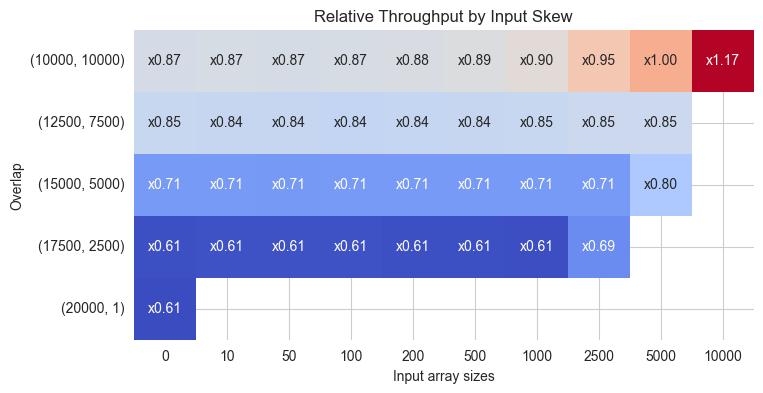

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(pivot_df, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar=False, ax=ax)

# Update x-axis labels with integer values
ax.set_xticklabels([int(x) for x in pivot_df.columns])

# Update y-axis labels with tuple string representation without decimal points
ax.set_yticklabels([f"({int(x[0])}, {int(x[1])})" for x in pivot_df.index])

for text in ax.texts:
    text.set_text(f"x{text.get_text()}")

ax.set_aspect('equal')
plt.xlabel('Input array sizes')
plt.ylabel('Overlap')
plt.title('Relative Throughput by Input Skew')
plt.show()

In [15]:
list(df['batch_name'])

['setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_0',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_100K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_25K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_50K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-100K_100K_75K',
 'setop-125K_75K_0',
 'setop-125K_75K_0',
 'seto

# Experiment 6: Setop with different distributions

In [82]:
df = read_measured('results/windows/experiment-6/*.log')
df = df[~df['mso'].str.contains('Scalar')].copy()
df['mso'] = df['mso'].str.replace(' SIMD', '')
df['distribution'] = df['batch_name'].apply(lambda s: s.split('_')[0].split('-')[1])
df = df[['mso', 'distribution', 'throughput']]
df

,mso,distribution,throughput
1,Union,exponential,4.088957
3,Intersect,exponential,4.726950
5,XOR,exponential,4.064024
7,Diff,exponential,4.650000
1,Union,exponential,4.106571
...,...,...,...
7,Diff,zipfian,1.893617
1,Union,zipfian,1.795031
3,Intersect,zipfian,1.740964
5,XOR,zipfian,1.773006


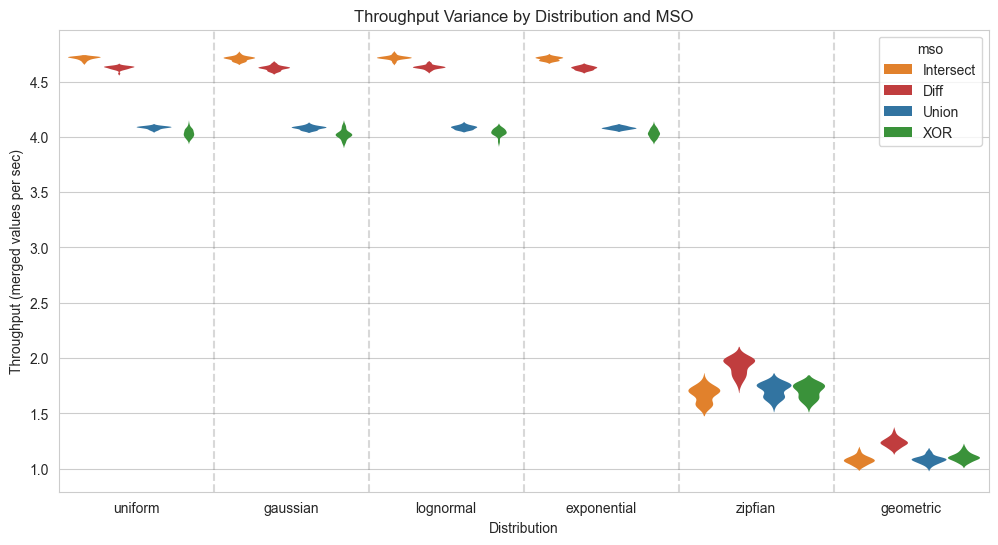

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the order of the distributions
order = ["uniform", "gaussian", "lognormal", "exponential", "zipfian", "geometric"]

# Set the order of the MSOs
hue_order = ["Intersect", "Diff", "Union", "XOR"]

# Set the style of the plot
sns.set_style("whitegrid")

# Set the color palette
palette = {"Union": "tab:blue", "Intersect": "tab:orange", "XOR": "tab:green", "Diff": "tab:red", "zipfian": "tab:purple", "geometric": "tab:brown"}

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x="distribution", y="throughput", hue="mso", data=df, inner=None, palette=palette, linewidth=0, edgecolor=None, width=0.9, order=order, hue_order=hue_order)

# Add vertical lines between the distribution groups
for i in range(len(order)-1):
    plt.axvline(x=i+0.5, linestyle="--", color="gray", alpha=0.3)

# Set the title and axis labels
plt.title("Throughput Variance by Distribution and MSO")
plt.xlabel("Distribution")
plt.ylabel("Throughput (merged values per sec)")

# Show the plot
plt.show()